In [1]:
import abc

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
np.seterr(all='raise', under='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [5]:
np.set_printoptions(precision=20)

In [6]:
from simple_nn.nn_layer import *
from simple_nn.activation_function import *
from simple_nn.gd_updater import *

---

In [7]:
class ActivationTanh(ActivationFunction):
    
    def __init__(self):
        """Init function. Do nothing."""
        pass
    
    @property
    def derivative_use_activated(self):
        return True
    
    def apply(self, v):
        return np.tanh(v)
    
    def derivative(self, v):
        return 1 - v**2

In [8]:
class ActivationLeakyRelu(ActivationFunction):
    """Relu function."""
    def __init__(self, alpha=0.3):
        """Init function. Set alpha value."""
        self.alpha = alpha
        pass
    
    @property
    def derivative_use_activated(self):
        """Use result to calculate derivative."""
        return True
    
    def apply(self, v):
        """Apply Relu to data.
        
        Args:
            v (np.array): Data
        
        Returns:
            v if v > 0, otherwise 0
        """
        return np.where(v>=0, v, self.alpha*v)
    
    def derivative(self, v):
        """Calculate derivative wrt input of activation function.
        
        Args:
            v (np.array): input of activation function if derivative_use_activated is false,
                output of activation function otherwise
        
        Returns:
            1 if v > 0, otherwise 0
        """
        return np.where(v>=0, 1, self.alpha)

---

gan model

In [9]:
class GANModel:
    def __init__(self, Z_size, X_size, gd_updater):
        self.Z_size = Z_size
        self.X_size = X_size
        self.gd_updater = gd_updater
        self.gen_model = []
        self.dis_model = []
    
    def add_gan_layer(self, layer):
        self.add_layer(self.Z_size, self.gen_model, layer)
    
    def add_dis_layer(self, layer):
        self.add_layer(self.X_size, self.dis_model, layer)
    
    def add_layer(self, init_size, model, layer):
        input_size = init_size
        if model:
            input_size = model[-1].node_count
        layer.init(input_size, self.gd_updater)
        model.append(layer)
    
    def model_forward(self, model, X, learning=True):
        cur_res = X
        for layer in model:
            cur_res = layer.forward(cur_res, learning=learning)
        return cur_res
    
    def generate(self, Z):
        return self.model_forward(self.gen_model, Z, learning=False)
    
    def back_probagation(self, model, y_predict, y):
        delta = np.atleast_2d(y_predict - y)
        for layer in reversed(model):
            delta = layer.back_propagation(delta, activation_derivatived=(layer==model[-1]))
        return delta
    
    def back_probagation_by_delta(self, model, delta):
        for layer in reversed(model):
            delta = layer.back_propagation(delta, activation_derivatived=False)
        return delta
    
    def update_model(self, model):
        for layer in model:
            layer.update()
    
    def train_dis(self, X, y):
        y_predict = self.model_forward(self.dis_model, X)
        self.back_probagation(self.dis_model, y_predict, y)
        self.update_model(self.dis_model)
        
    def train_gen(self, Z):
        X = self.model_forward(self.gen_model, Z, learning=True)
        y_predict = self.model_forward(self.dis_model, X)
        delta_dis = self.back_probagation(self.dis_model, y_predict, np.ones(y_predict.shape))
        self.back_probagation_by_delta(self.gen_model, delta_dis)
        self.update_model(self.gen_model)

---

test

In [10]:
sample_n = 10000

In [11]:
train_X_org = \
    np.tile(np.linspace(0, np.pi*2, num=50), (sample_n, 1)) \
    + np.tile(np.random.rand(sample_n,1), (1, 50))

In [13]:
train_X = np.sin(train_X_org)

In [14]:
train_X.shape

(10000, 50)

In [15]:
learning_rate = 0.02

In [82]:
m = GANModel(Z_size=3, X_size=50, gd_updater = GDUpdaterNormal(learning_rate=learning_rate))

In [83]:
m.add_gan_layer(FCLayer(20, True, ActivationLeakyRelu()))
m.add_gan_layer(FCLayer(50, True, ActivationTanh()))
m.add_dis_layer(FCLayer(20, True, ActivationLeakyRelu()))
m.add_dis_layer(FCLayer(1, True, ActivationSigmoid()))

In [84]:
batch_size = 100
epoch = 5000

In [85]:
%%time
for i in range(epoch):
    if not i%100:
        print('epoch {}'.format(i))
    learning_idx = np.arange(sample_n)
    np.random.shuffle(learning_idx)
    for start_idx in range(0, sample_n, batch_size):
        data_idx = learning_idx[start_idx : min(start_idx+batch_size,sample_n)]
        Z = np.random.rand(batch_size, 3)
        X = m.generate(Z)
        m.train_dis(X, np.zeros((len(X),1)))
        m.train_dis(train_X[data_idx], np.ones((len(X),1)))
#         m.train_gen(Z)
        m.train_gen(np.random.rand(batch_size, 3))

epoch 0
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900
epoch 1000
epoch 1100
epoch 1200
epoch 1300
epoch 1400
epoch 1500
epoch 1600
epoch 1700
epoch 1800
epoch 1900
epoch 2000
epoch 2100
epoch 2200
epoch 2300
epoch 2400
epoch 2500
epoch 2600
epoch 2700
epoch 2800
epoch 2900
epoch 3000
epoch 3100
epoch 3200
epoch 3300
epoch 3400
epoch 3500
epoch 3600
epoch 3700
epoch 3800
epoch 3900
epoch 4000
epoch 4100
epoch 4200
epoch 4300
epoch 4400
epoch 4500
epoch 4600
epoch 4700
epoch 4800
epoch 4900
Wall time: 13min 30s


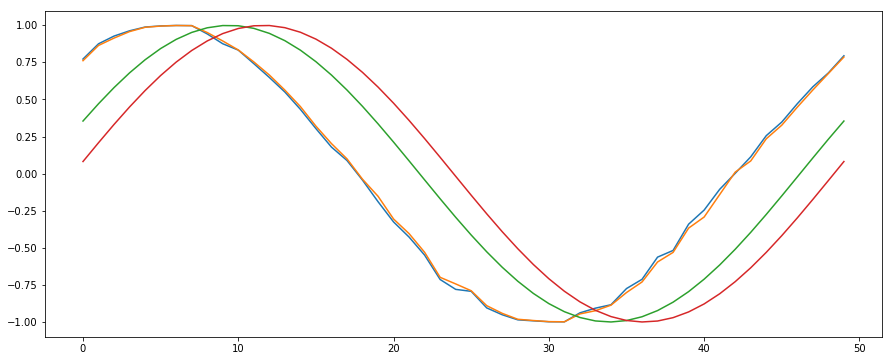

In [86]:
plt.figure(figsize=(15,6))
plt.plot(m.generate(np.random.rand(3)))
plt.plot(m.generate(np.random.rand(3)))
plt.plot(train_X[0])
plt.plot(train_X[1])
plt.show()

In [87]:
m.model_forward(m.dis_model, m.generate(np.random.rand(batch_size, 3)), learning=False)

array([[ 0.50171030818860884448],
       [ 0.50273063183651101049],
       [ 0.502405375275454813  ],
       [ 0.50263527969802068718],
       [ 0.50215334053064830666],
       [ 0.50208542234528463766],
       [ 0.50076178886967037673],
       [ 0.50198059921602011801],
       [ 0.50236903052520698321],
       [ 0.50284517971214581777],
       [ 0.50130619816298838121],
       [ 0.49989743000067393686],
       [ 0.50203222870327968153],
       [ 0.50135055579604703713],
       [ 0.50147237442733760826],
       [ 0.50184861702924210558],
       [ 0.50195188392937362121],
       [ 0.50089160353335127063],
       [ 0.50030803485377028927],
       [ 0.50200448173086587023],
       [ 0.50232055660606900194],
       [ 0.50219291833972345973],
       [ 0.50030232392811613273],
       [ 0.50193638194569967226],
       [ 0.50013069253219710752],
       [ 0.50090680970955858697],
       [ 0.50245295480362728302],
       [ 0.5022308655356120255 ],
       [ 0.50275196190323045986],
       [ 0.502

In [88]:
m.model_forward(m.dis_model, train_X[:batch_size], learning=False)

array([[ 0.50324572900958564059],
       [ 0.50339497835238333767],
       [ 0.50364296166685940115],
       [ 0.50298802081624927052],
       [ 0.50051215001733651011],
       [ 0.50187899549657710718],
       [ 0.50338949142448818908],
       [ 0.50355479788485446591],
       [ 0.50227050939393158568],
       [ 0.50389161344646826723],
       [ 0.50060949376099161956],
       [ 0.50389839938377700701],
       [ 0.50140917041306798385],
       [ 0.5040924508861497344 ],
       [ 0.50046196198287329349],
       [ 0.50300966296157889612],
       [ 0.50365575685742802747],
       [ 0.50386627707571440826],
       [ 0.50305447498932553962],
       [ 0.50385807336958643443],
       [ 0.5013740914809173832 ],
       [ 0.5035253772542801487 ],
       [ 0.50349429489932040482],
       [ 0.50364186383236597688],
       [ 0.50105840403328294475],
       [ 0.50426179496757128629],
       [ 0.50285665603791629419],
       [ 0.50368853059266260885],
       [ 0.50189685549047635682],
       [ 0.503